<a href="https://www.kaggle.com/code/davidfmora/tpsnov22-isotonic-calibration-lgbmclassifier?scriptVersionId=111243732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Tabular Playground Series November 2022**

**TODO**: 
- Reformat the training code to experiment more easily
- Dig into calibrating the input models via Isotonic regression or Logistic regresion on logits
- Perform Hyperparameter tuning [x]
- Dig into blending the models correctly
- Try some autoML tools


### Problem description

There's a total of 5000 submissions to a binary classification task. Each submission consists of 40000 predictions, amongst 20000 of which we now the true labels.

### Libraries

First import the required dependencies:

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os 
from pathlib import Path
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from scipy.special import logit
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_style("dark")
%matplotlib inline

# **Exploratory Data Analysis**

We first load the the data, we will use load a pickle file that contains a numpy array with all the submissions:

In [2]:
%%time
path = Path('/kaggle/input/tabular-playground-series-nov-2022/')
submission = pd.read_csv(path / 'sample_submission.csv', index_col='id')
labels = pd.read_csv(path / 'train_labels.csv', index_col='id')

# load subs file
with open('../input/submissions-pickle-file/subs.pickle', 'rb') as f: 
    X = pickle.load(f)

# list of files in the submission folder
subs = sorted(os.listdir(path / 'submission_files'))

# first 20_0000 subs we know the ground truth
y = labels["label"].values

CPU times: user 526 ms, sys: 3.14 s, total: 3.66 s
Wall time: 21 s


We now plot the distribution of the log-loss values of the submissions:

**Insights**

- The distribution of log-loss values seems to be symetric and bimodal.
- There seems to be a lot of submissions with log-loss values close to 0.69 and 0.71
- Most predictions are really bad, as a lot of them perform worse than a dummy model(predicts 0.5 always)

In [3]:
dummy_model = np.zeros((20000,), np.float64) + 0.5
print(f"log-loss of dummy model: {log_loss(y, dummy_model)}")

log-loss of dummy model: 0.6931471805599453


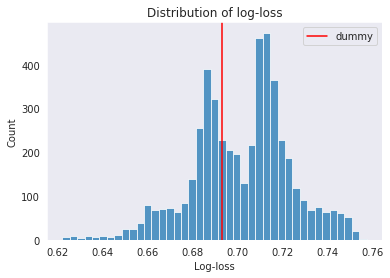

In [4]:
# log-loss values for each submission
subs_loss_vals = np.apply_along_axis(lambda x: log_loss(labels, x), 0, X[:20000])

# histogram
sns.histplot(subs_loss_vals)
plt.axvline(x=log_loss(y, dummy_model), color="r", label="dummy")
plt.xlabel("Log-loss")
plt.title("Distribution of log-loss")
plt.legend()
plt.show()

The columns are alredy ordered by the log-loss:

In [5]:
pd.Series(subs_loss_vals).is_monotonic_increasing


True

### Null values and Outliers

There also does not seem to be any null values in the predictions.

In [6]:
print(f"Number of null values in X: {np.isnan(X).sum()}")
print(f"Number of null values in y: {np.isnan(y).sum()}")

Number of null values in X: 0
Number of null values in y: 0


We can see that although the predicted probabilities should be values between 0 and 1. There are predictions that exceed this limits. We can either clip all the submission values to the interval [0, 1]. Or maybe just dropping these subs is better, it may mitigate overfitting because there is less features

In [7]:
print(f"Minimum predicted value: {X.min()}")
print(f"Maximum predicted value: {X.max()}")

Minimum predicted value: -0.376186
Maximum predicted value: 1.356611


We can see that the classes are balanced.

In [8]:
y.mean()

0.5

### **Predictions histograms**

We next examine a few submissions, we can see that most of them seem to be skeewed towards 1, which is unusual considering that the classes are balanced.

**Insights**

- We somehow have to deal with the diversity of the distributions. An underconfident model (e.g., number 917) should get a higher weight in the ensemble than a more confident model (e.g., number 0). ___How can I identify the confidents models from the undercondident ones.___
- Rank ensembling is an option.
- Maybe we can improve the logloss by transforming the imbalanced predictions to make them more balanced.
- Maybe the word "ensemble" in the competition description has been put there only as a distraction. It will be advantageous if we think of this competition as a standard binary classification problem with 5000 features. We can use any classification model and should not focus on the models which are usually used in ensembling. Of course we need a model which can predict probabilities (e.g., LogisticRegression has a predict_proba function, RidgeClassifier hasn't).


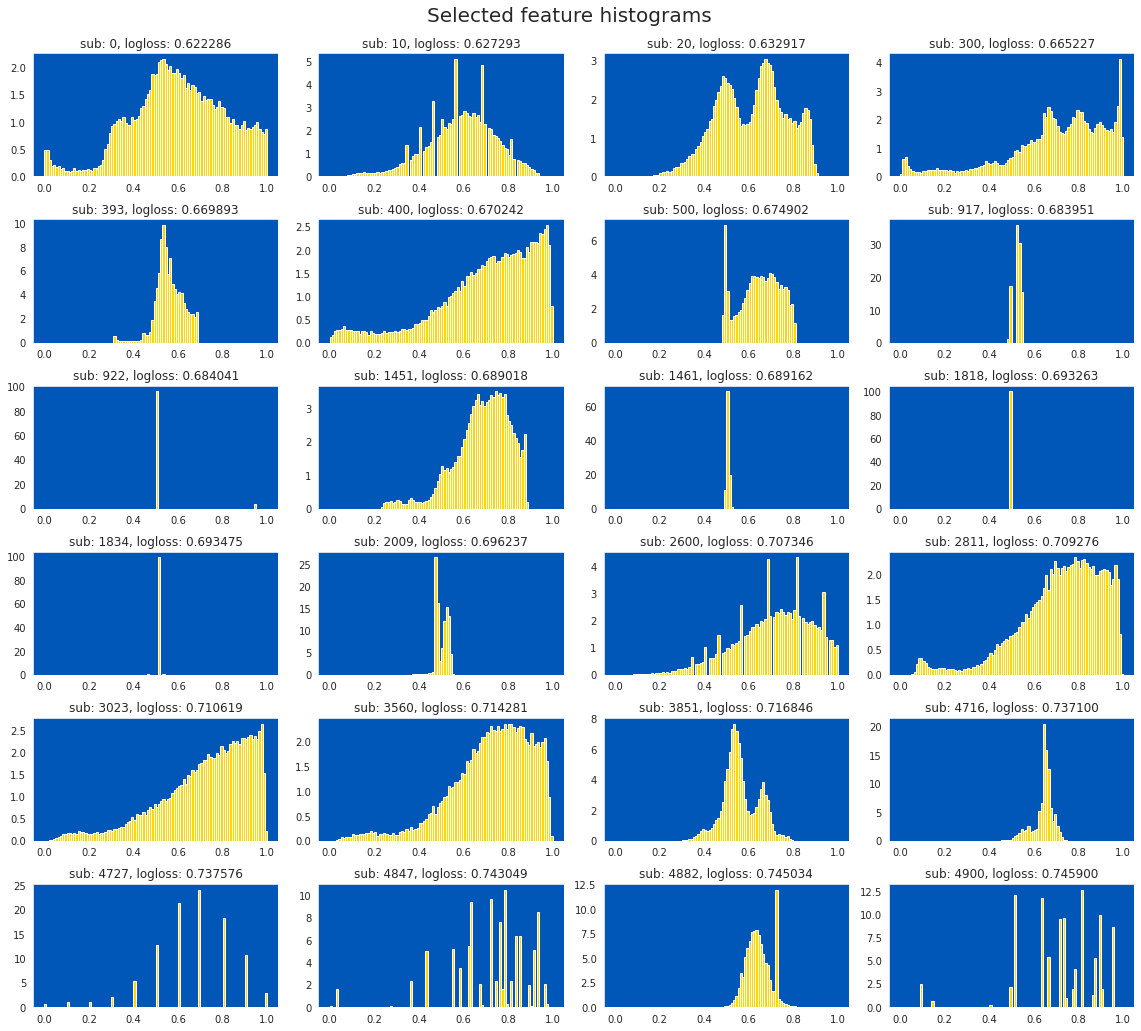

In [9]:
# code extracted from AmbrosM notebook 

sample_subs = [0, 10, 20, 300, 393, 400, 500, 917,
               922, 1451, 1461, 1818, 1834, 2009, 2600, 2811,
               3023, 3560, 3851, 4716, 4727, 4847, 4882, 4900]
_, axs = plt.subplots(6, 4, figsize=(16, 14))
axs = axs.ravel()
for i, sub in enumerate(sample_subs):
    axs[i].hist(X[:,sub], range=(0, 1), bins=100, density=True, color='#ffd700')
    axs[i].set_title(f"sub: {sub}, logloss: {log_loss(y, X[:20_000,sub]):5f}")
    axs[i].set_facecolor('#0057b8') # blue
plt.tight_layout(h_pad=1.0)
plt.suptitle('Selected feature histograms', y=1.02, fontsize=20)
plt.show()


### Calibration of classifiers

**Question**: ¿Why does calibration the models from the submission improve the logloss of the meta model?

We now plot the calibration plots for some models

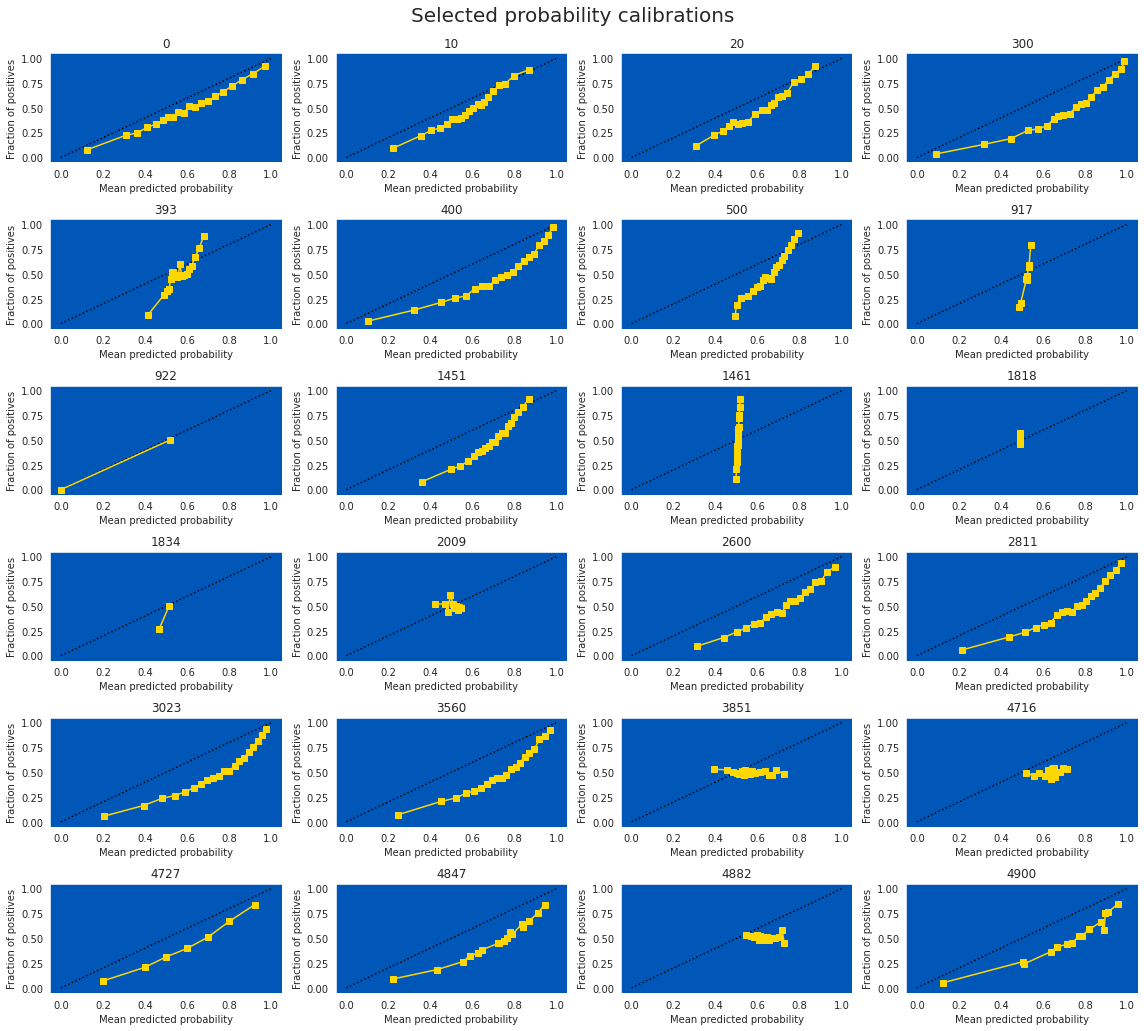

In [10]:
_, axs = plt.subplots(6, 4, figsize=(16, 14))
axs = axs.ravel()
for i, sub in enumerate(sample_subs):
    CalibrationDisplay.from_predictions(y, X[:20_000,sub].clip(0, 1), n_bins=20,
                                        strategy='quantile', ax=axs[i], color='#ffd700')
    axs[i].set_title(f"{sub}")
    axs[i].set_facecolor('#0057b8') # blue
    axs[i].legend('', frameon=False)
plt.tight_layout(h_pad=1.0)
plt.suptitle('Selected probability calibrations', y=1.02, fontsize=20)
plt.show()

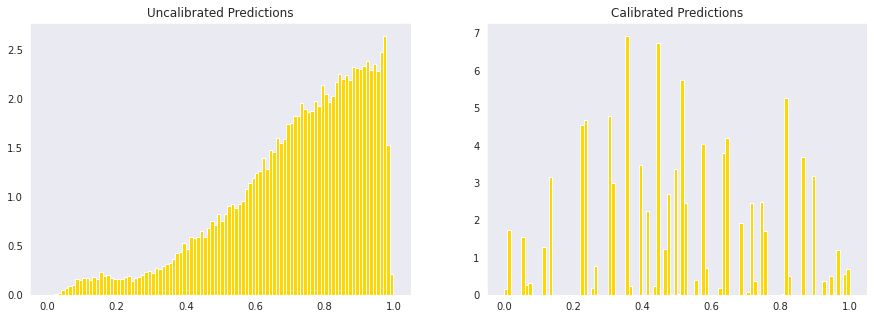

In [11]:
example_sub = X[:, 3023]
iso_reg = IsotonicRegression()
iso_reg.fit(example_sub[:20_000], y)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()

axs[0].hist(X[:,3023], range=(0, 1), bins=100, density=True, color='#ffd700')
axs[0].set_title("Uncalibrated Predictions")


axs[1].hist(iso_reg.predict(X[:,3023]), range=(0, 1), bins=100, density=True, color='#ffd700')
axs[1].set_title("Calibrated Predictions")

plt.show()

### Principal Components Analysis

In [12]:
%%time

pca = PCA()
pca.fit(X)

CPU times: user 12min 4s, sys: 27.1 s, total: 12min 31s
Wall time: 3min 16s


PCA()

We can see that 95% of the variance is explained by the first 7 components. 

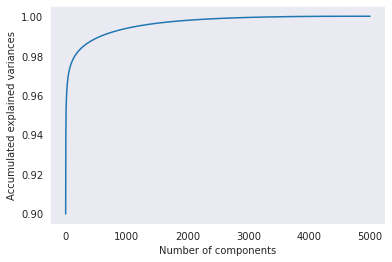

The 7 PCs explain about 95% of the variance


In [13]:
evr = pca.explained_variance_ratio_
cumsum = np.cumsum(evr)
plt.plot(cumsum)
plt.ylabel("Accumulated explained variances")
plt.xlabel("Number of components")
plt.show()

print(f"The {np.argmax(cumsum >= 0.95) + 1} PCs explain about 95% of the variance")

# **Data Cleaning & Feature Engineering**

Ideas
- 

I've read that there are too many features for an ensembling problem and this may cause overfitting. Assuming this is true, how can I reduce the number of features:
- ¿Is this a use case for PCA?
- ¿Just select the top $n$ subs and add more as CV improves?
- Use the top performing subs under log-loss or AUC, is this loss of information significant?

In [14]:
%%time

with open('../input/submissions-pickle-file/subs.pickle', 'rb') as f: 
    X = pickle.load(f)

# select top 200 subs under log-loss
X = X[:, :200]

# I decided to drop instead of clip
# X = np.clip(X, 1e-6, 1-1e-6)

# Let's drop the outlier submissions:
mask = ((X >= 0) & (X <= 1)).all(axis=0)
X = X[:, mask]

# Calibrate sumbission models
def iso_cal(X):
    # Question: ¿Why does Isotonic Regression give nan values when out of bounds?
    iso = IsotonicRegression(out_of_bounds="clip").fit(X[:20_000], y)
    
    return iso.predict(X)


def iso_cal_with_cv(X):
    X_dev = X[:20_000]
    X_test = X[20_000:]
    
    X_cal = np.zeros(X.shape)
    
    kfold = KFold()
    
    for tr_idx, va_idx in kfold.split(X_dev, y):
        X_tr = X_dev[tr_idx]
        X_va = X_dev[va_idx]
        y_tr = y[tr_idx]
        
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(X_tr, y_tr)
        oof = iso.predict(X_va)
        X_cal[va_idx] = oof
    
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(X_dev, y)
    X_cal[20_000:] = iso.predict(X_dev)
    
    return X_cal
    

def logit_cal(X):
    logit_logreg = LogisticRegression(C=0.2541, max_iter=1000, random_state=0)
    X_tr = logit(X[:20_000].clip(1e-6, 1-1e-6)).reshape(-1, 1)
    logit_logreg.fit(X_tr, y)
    
    return logit_logreg.predict_proba(X.reshape(-1, 1))[:,1]

# calibrate models
X = np.apply_along_axis(iso_cal, 0, X)

# split in train and test subsets
X_dev = X[:20_000]
X_test = X[20_000:]

print(X_dev.shape)
print(X_test.shape)

(20000, 197)
(20000, 197)
CPU times: user 2.09 s, sys: 2.23 s, total: 4.32 s
Wall time: 4.32 s


# **Baseline models**

Let's train and cross-validate some models. As the classes are balanced stratified K-fold might not be necessary.

Overall it seems that choosing the top subs(200-300) under log-loss performs better than using PCA, this might be due to the fact that PCA preserves variance, which might mostly come from bad models, but does not take into consideration the loss.

In [15]:
overall_oof = pd.DataFrame()

def plot_oof_histogram(name, oof, title=None):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.hist(oof, range=(0, 1), bins=100, density=True, color='#ffd700')
    ax1.set_title(f"{name} prediction histogram")
    ax1.set_facecolor('#0057b8') # blue
    
    CalibrationDisplay.from_predictions(y, oof, n_bins=20,
                                        strategy='quantile', ax=ax2, color='#ffd700')
    ax2.set_title('Probability calibration')
    ax2.set_facecolor('#0057b8') # blue
    ax2.legend('', frameon=False)
    if title is not None:
        plt.suptitle(title, y=1.0, fontsize=20)
    plt.show()

### **Logistic Regression**


First we try to use PCA to reduce de dataset to 50 components:

In [16]:
%%time

# 0.52465 PL
oof_logreg = np.zeros(len(X_dev))

def cv_logreg(X_dev):
    kfold = StratifiedKFold(shuffle=True, random_state=1)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_dev, y)):
        X_tr = X_dev[tr_idx]
        X_va = X_dev[va_idx]
        y_tr = y[tr_idx]
        y_va = y[va_idx]

        log_reg = make_pipeline(
            LogisticRegression(C=0.2541, max_iter=1000, random_state=0)
        )
        log_reg.fit(X_tr, y_tr)

        y_va_pred = log_reg.predict_proba(X_va)[:,1]
        score = log_loss(y_va, y_va_pred)
        oof_logreg[va_idx] = y_va_pred
        
        print(f"Fold {fold}: log-loss = {score:.5f}")
        scores.append(score)
        
    print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")
    
cv_logreg(X_dev)

Fold 0: log-loss = 0.51869
Fold 1: log-loss = 0.53343
Fold 2: log-loss = 0.52175
Fold 3: log-loss = 0.52860
Fold 4: log-loss = 0.51838

Average log-loss 0.52417

CPU times: user 15.7 s, sys: 5.25 s, total: 20.9 s
Wall time: 5.29 s


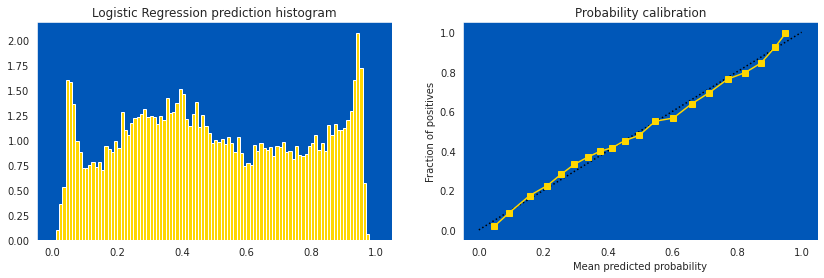

In [17]:
overall_oof["logreg"] = oof_logreg
plot_oof_histogram("Logistic Regression", oof_logreg)

In [18]:
# 0.532309828091498 -> saga
# 0.5356786035569426 -> saga + C=0.01
# 0.5323027248276102 -> lbgfs
# 0.530233561134047 -> top 200 
# 0.5301734827851791 -> top 300
neg_loglosses = cross_val_score(
    LogisticRegression(C=0.2541, max_iter=1000, random_state=0),
    X_dev, 
    y, 
    scoring='neg_log_loss', 
    cv=5)

-neg_loglosses.mean()

0.5252565597448119

### **LGMB**

We first fit a baseline baseline classifier and then tune the hyperparameters using Optuna

Fold 0: log-loss = 0.51874
Fold 1: log-loss = 0.53189
Fold 2: log-loss = 0.52473
Fold 3: log-loss = 0.52579
Fold 4: log-loss = 0.52041

Average log-loss 0.52431



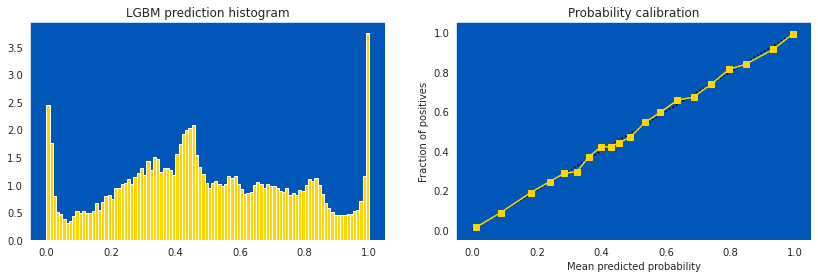

CPU times: user 18.3 s, sys: 222 ms, total: 18.5 s
Wall time: 5.54 s


In [19]:
%%time

oof_lgbm = np.zeros(len(X_dev))

def cv_lgbm(X_dev, params={"max_depth": 3, "random_state": 0}):
    
    str_kfold = StratifiedKFold(shuffle=True, random_state=1, n_splits=5)
    scores = []

    for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev, y)):
        X_tr = X_dev[tr_idx]
        X_va = X_dev[va_idx]
        y_tr = y[tr_idx]
        y_va = y[va_idx]

        lgb_md = make_pipeline(LGBMClassifier(**params))

        lgb_md.fit(X_tr, y_tr)

        lgb_pred = lgb_md.predict_proba(X_va)[:, 1]
        score = log_loss(y_va, lgb_pred)
        oof_lgbm[va_idx] = lgb_pred
        
        print(f"Fold {fold}: log-loss = {score:.5f}")
        scores.append(score)

    print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")
    
cv_lgbm(X_dev)
plot_oof_histogram("LGBM", oof_lgbm)

Let's tune the hyperparameters of the LGBMClassifier using Optuna:

In [20]:
def objective(trial, data=X_dev[:, :200], target=y):   
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
                         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
        'n_jobs' : -1, 
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'logloss',
        'device': 'gpu'
    }
    model = LGBMClassifier(**params)  
        
    neg_loglosses = cross_val_score(make_pipeline(LGBMClassifier(**params)),
                                data, 
                                target, 
                                scoring='neg_log_loss', 
                                cv=3
                               )
            
    return -neg_loglosses.mean()

In [21]:
# Hyperparameters tuning take about 30 minutes, unraw the cell to perform tuning

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)
# print('Number of finished trials: ', len(study.trials))
# print('Best trial: ', study.best_trial.params)
# print('Best value: ', study.best_value)


The parameters that we got are the following:

In [22]:
best_params = {'reg_alpha': 1.4555494564300762,
               'reg_lambda': 9.030650638749616,
               'num_leaves': 12,
               'min_child_samples': 62,
               'max_depth': 5,
               'learning_rate': 0.01,
               'colsample_bytree': 0.12484633816533297,
               'n_estimators': 626,
               'cat_smooth': 18,
               'cat_l2': 17,
               'min_data_per_group': 50}


We fit the classifier again:

In [23]:
oof_lgbm = np.zeros(len(X_dev))

cv_lgbm(X_dev, params=best_params)
overall_oof["lgbm"] = oof_lgbm

Fold 0: log-loss = 0.51889
Fold 1: log-loss = 0.53156
Fold 2: log-loss = 0.52290
Fold 3: log-loss = 0.52607
Fold 4: log-loss = 0.51947

Average log-loss 0.52378



There is a small improvement from 0.52431 to 0.52378 in the CV score. 

### Extra Trees

Fold.0: log-loss = 0.51814
Fold.1: log-loss = 0.52982
Fold.2: log-loss = 0.52009
Fold.3: log-loss = 0.52376
Fold.4: log-loss = 0.51779

Average log-loss 0.52192



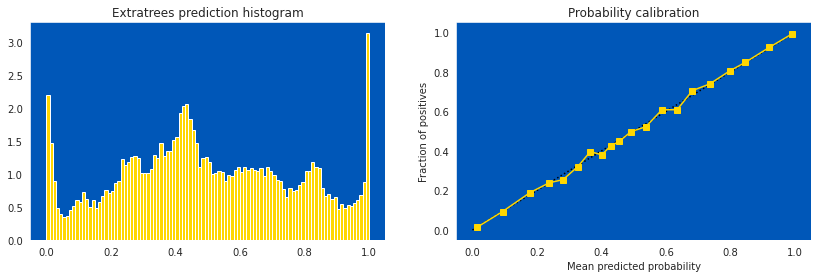

CPU times: user 40 s, sys: 169 ms, total: 40.2 s
Wall time: 40 s


In [24]:
%%time

oof_ext_trees = np.zeros(len(X_dev))
str_kfold = StratifiedKFold(shuffle=True, random_state=1)
scores = []

for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev, y)):
    X_tr = X_dev[tr_idx]
    X_va = X_dev[va_idx]
    y_tr = y[tr_idx]
    y_va = y[va_idx]
    
    extra_trees = make_pipeline(
        ExtraTreesClassifier(n_estimators=200, min_samples_leaf=12, random_state=1)
    )
    
    extra_trees.fit(X_tr, y_tr)
    
    y_va_pred = extra_trees.predict_proba(X_va)[:,1]
    score = log_loss(y_va, y_va_pred)
    oof_ext_trees[va_idx] = y_va_pred
    
    print(f"Fold.{fold}: log-loss = {score:.5f}")
    scores.append(score)

print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")

overall_oof["extra_trees"] = oof_ext_trees
plot_oof_histogram("Extratrees", oof_ext_trees)

### **Models CV and PL**

Something that I can't quite understand is the following. For the LGBM classifier I got the following CV and PL scores:

**CV** = 0.52378

**PL** = 0.51592

For the Extra Tree model I got a CV score of:

**CV** = 0.52192

**PL** = 0.51724

I have a couple of questions regarding this results: 

- ¿Why is the PL score so much better than the CV one for the LGBM classifier?. Note that the submission that got the PL score was fitted on more data than the CV model but is this result normal still?

- ¿Why did the Extra Trees model got worst PL score than the LGBM one despite having a better CV score?

Having said all of this, I find myself a bit confused on how to get the best sense for my models performance

### **Stacked Model**

In [25]:
X_dev_ensemble = overall_oof.values

str_kfold = StratifiedKFold(shuffle=True, random_state=1)
scores = []

for fold, (tr_idx, va_idx) in enumerate(str_kfold.split(X_dev_ensemble, y)):
    X_tr = X_dev_ensemble[tr_idx]
    X_va = X_dev_ensemble[va_idx]
    y_tr = y[tr_idx]
    y_va = y[va_idx]
    
    blend_model = Ridge(alpha=1e-1, positive=True, fit_intercept=False)
    blend_model.fit(X_tr, y_tr)
    print(blend_model.coef_)
    
    y_va_pred = blend_model.predict(X_va).clip(0, 1)
    score = log_loss(y_va, y_va_pred)
    
    print(f"Fold.{fold}: log-loss = {score:.5f}")
    scores.append(score)

print(f"\nAverage log-loss {sum(scores) / len(scores):.5f}\n")


[0.44544179 0.19816995 0.35405894]
Fold.0: log-loss = 0.51690
[0.37193104 0.29745405 0.33256686]
Fold.1: log-loss = 0.52964
[0.4421035  0.22200273 0.3362129 ]
Fold.2: log-loss = 0.51937
[0.3740727  0.29939763 0.3304784 ]
Fold.3: log-loss = 0.52428
[0.44311571 0.20143166 0.35688038]
Fold.4: log-loss = 0.51656

Average log-loss 0.52135



In [26]:
meta_preds = np.zeros((20_000, 3))

estimators = [
    LogisticRegression(C=0.2541, max_iter=1000, random_state=0),
    LGBMClassifier(**best_params),
    ExtraTreesClassifier(n_estimators=200, min_samples_leaf=12, random_state=1)
    ]

for idx, estimator in enumerate(estimators):
    estimator.fit(X_dev, y)
    meta_preds[:, idx] = estimator.predict_proba(X_test)[:,1]

In [27]:
final_blend_model = Ridge(alpha=1e-1, positive=True, fit_intercept=False)
final_blend_model.fit(X_dev_ensemble, y)

pred = final_blend_model.predict(meta_preds).clip(0, 1)
final_blend_model.coef_

array([0.45949403, 0.20182727, 0.33939264])

In [28]:
submission["pred"] = pred
submission.to_csv("submission.csv")